<a href="https://colab.research.google.com/github/ervengil1/CNNPPT/blob/main/PPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2

import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

In [ ]:
#Descargar el dataset de perros y gatos
datos, metadatos = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)

Preparar datos

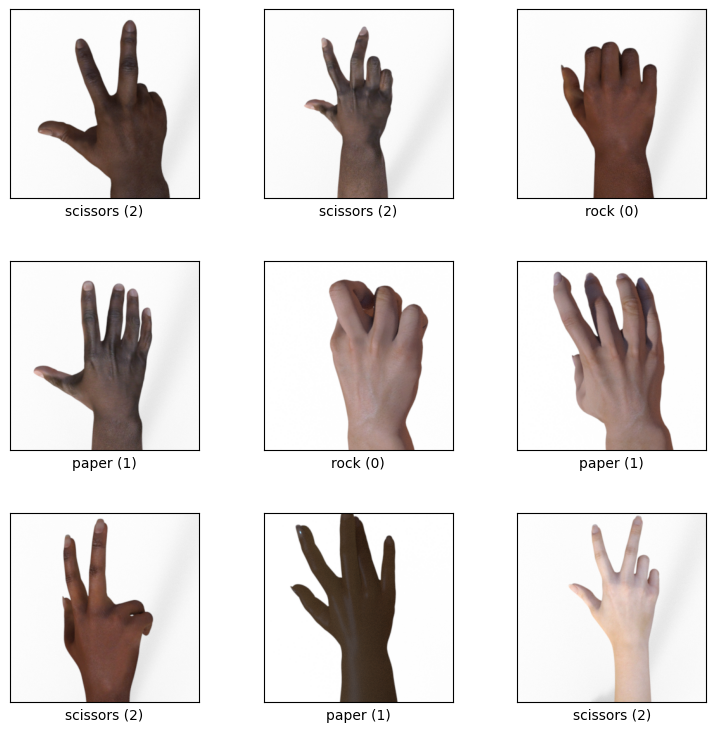

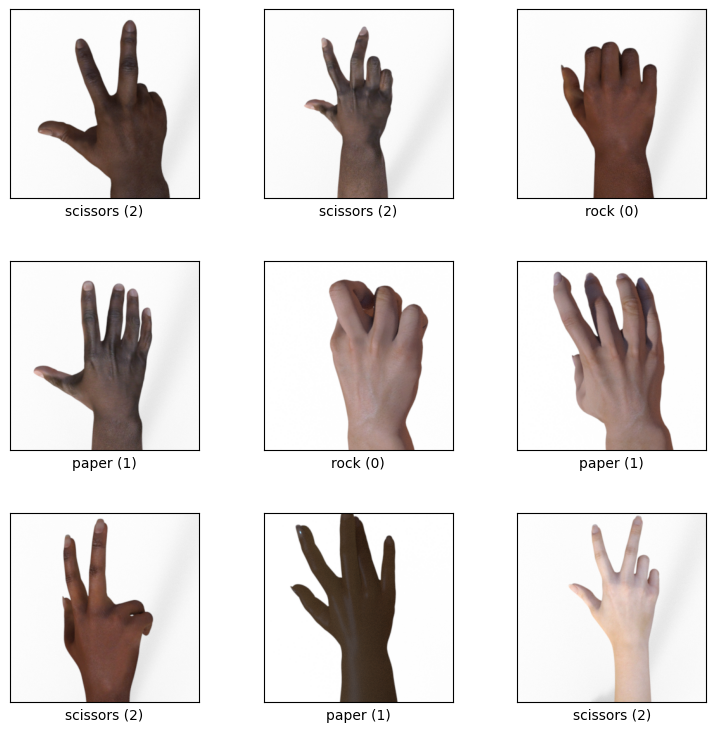

In [ ]:
#Mostrar ejemplos del set
tfds.show_examples(datos['train'], metadatos)

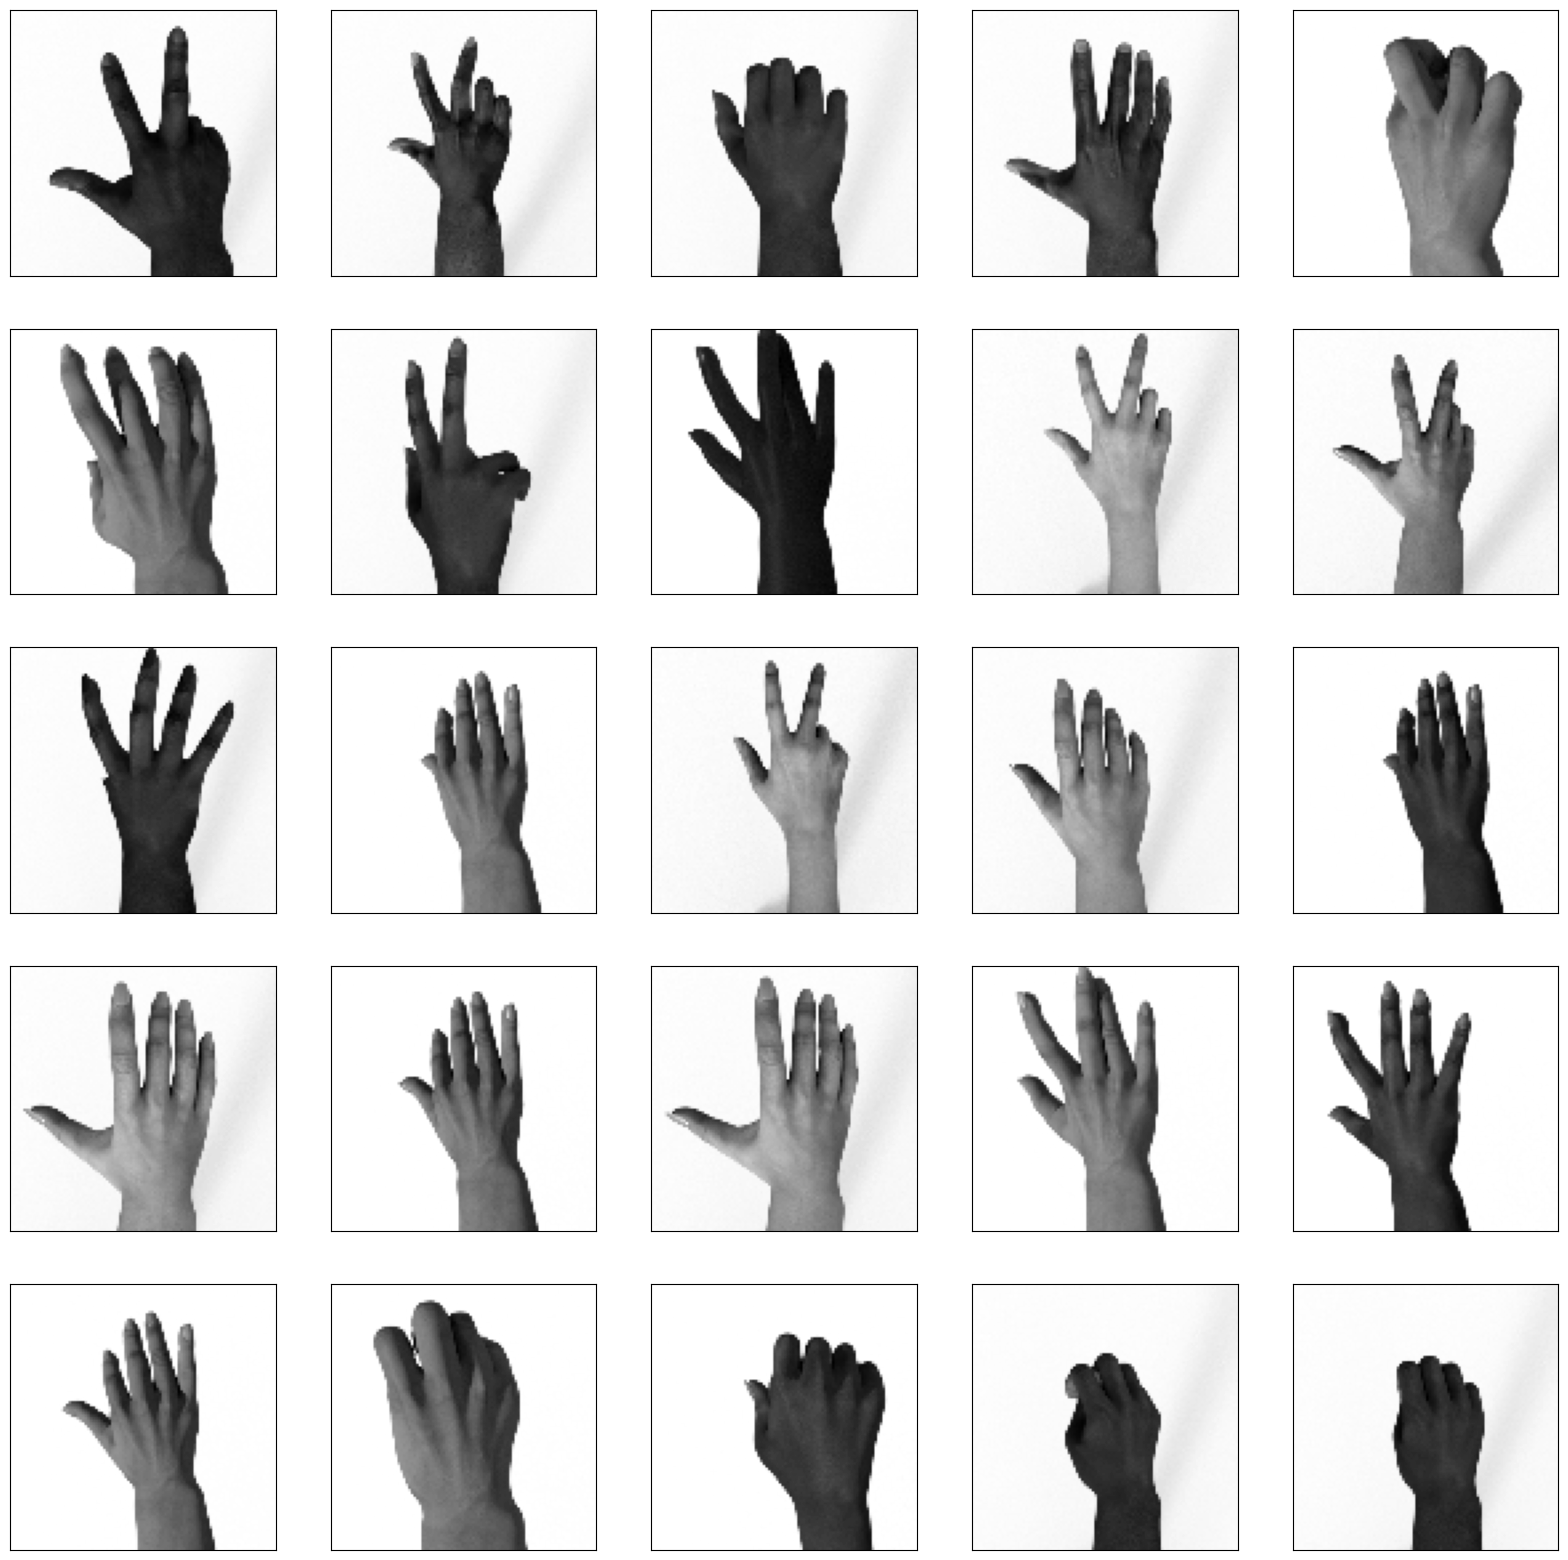

In [ ]:
#Manipular y visualizar el set
#Lo pasamos a TAMANO_IMG (100x100) y a blanco y negro (solo para visualizar)

plt.figure(figsize=(20,20))

TAMANO_IMG=100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

In [ ]:
#Variable que contendra todos los pares de los datos (imagen y etiqueta) ya modificados (blanco y negro, 100x100)
datos_entrenamiento = []

for i, (imagen, etiqueta) in enumerate(datos['train']): #Todos los datos
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Cambiar tamano a 100,100,1
  datos_entrenamiento.append([imagen, etiqueta])

In [ ]:
#Ver los datos del primer indice
datos_entrenamiento[0]

[array([[[254],
         [254],
         [254],
         ...,
         [252],
         [251],
         [251]],
 
        [[254],
         [252],
         [254],
         ...,
         [251],
         [251],
         [250]],
 
        [[255],
         [253],
         [253],
         ...,
         [251],
         [251],
         [250]],
 
        ...,
 
        [[251],
         [251],
         [252],
         ...,
         [248],
         [247],
         [249]],
 
        [[252],
         [251],
         [251],
         ...,
         [248],
         [248],
         [249]],
 
        [[252],
         [252],
         [252],
         ...,
         [246],
         [247],
         [247]]], dtype=uint8),
 <tf.Tensor: shape=(), dtype=int64, numpy=2>]

In [ ]:
len(datos_entrenamiento)

2520

In [ ]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (piedra,  papel o tijeras)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

Normalizar

In [ ]:
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
X = np.array(X).astype(float) / 255

In [ ]:
X

array([[[[0.99607843],
         [0.99607843],
         [0.99607843],
         ...,
         [0.98431373],
         [0.98823529],
         [0.98431373]],

        [[0.99607843],
         [0.99607843],
         [0.99215686],
         ...,
         [0.98431373],
         [0.98823529],
         [0.98431373]],

        [[0.99607843],
         [0.99607843],
         [0.98823529],
         ...,
         [0.98431373],
         [0.98431373],
         [0.98039216]],

        ...,

        [[0.99215686],
         [0.98431373],
         [0.98431373],
         ...,
         [0.97254902],
         [0.97254902],
         [0.96862745]],

        [[0.98431373],
         [0.99215686],
         [0.98823529],
         ...,
         [0.97254902],
         [0.96862745],
         [0.97254902]],

        [[0.99215686],
         [0.98823529],
         [0.98431373],
         ...,
         [0.96862745],
         [0.97647059],
         [0.97254902]]],


       [[[1.        ],
         [0.99215686],
         [0.99

In [ ]:
#Convertir etiquetas en arreglo simple
y = np.array(y)

In [ ]:
y

array([2, 2, 0, ..., 1, 1, 1])

In [ ]:
X.shape

(2520, 100, 100, 1)

Modelo CNN

In [ ]:
modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modeloCNN.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
#La variable de tensorboard se envia en el arreglo de "callbacks" (hay otros tipos de callbacks soportados)
#En este caso guarda datos en la carpeta indicada en cada epoca, de manera que despues
#Tensorboard los lee para hacer graficas
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
modeloCNN.fit(X, y, batch_size=32,
                validation_split=0.20,
                epochs=25,
                callbacks=[tensorboardCNN])

Epoch 1/25
63/63 [==============================] - 3s 21ms/step - loss: nan - accuracy: 0.3279 - val_loss: nan - val_accuracy: 0.3492
Epoch 2/25
63/63 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.3294 - val_loss: nan - val_accuracy: 0.3492
Epoch 3/25
63/63 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.3294 - val_loss: nan - val_accuracy: 0.3492
Epoch 4/25
63/63 [==============================] - 1s 14ms/step - loss: nan - accuracy: 0.3294 - val_loss: nan - val_accuracy: 0.3492
Epoch 5/25
63/63 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.3294 - val_loss: nan - val_accuracy: 0.3492
Epoch 6/25
63/63 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.3294 - val_loss: nan - val_accuracy: 0.3492
Epoch 7/25
63/63 [==============================] - 1s 14ms/step - loss: nan - accuracy: 0.3294 - val_loss: nan - val_accuracy: 0.3492
Epoch 8/25
63/63 [==============================] - 1s 

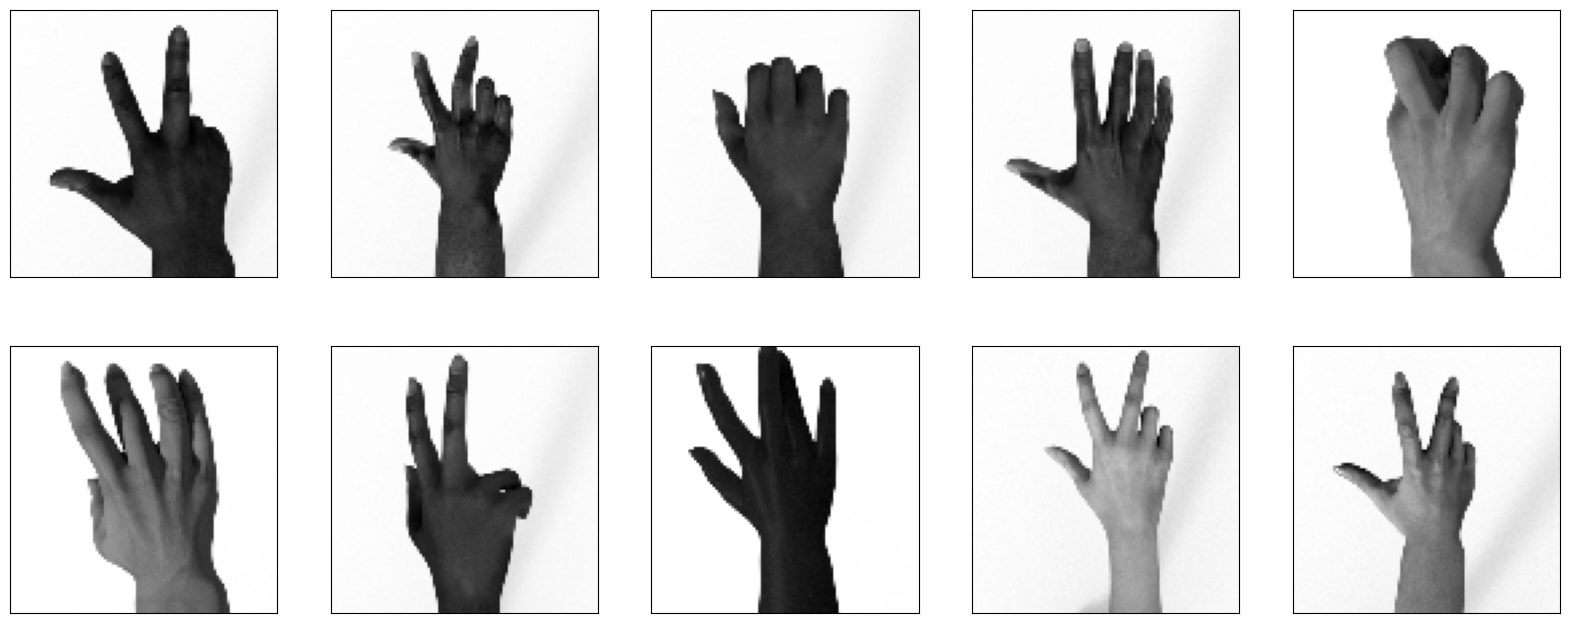

In [ ]:
#ver las imagenes de la variable X sin modificaciones por aumento de datos
plt.figure(figsize=(20, 8))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X[i].reshape(100, 100), cmap="gray")

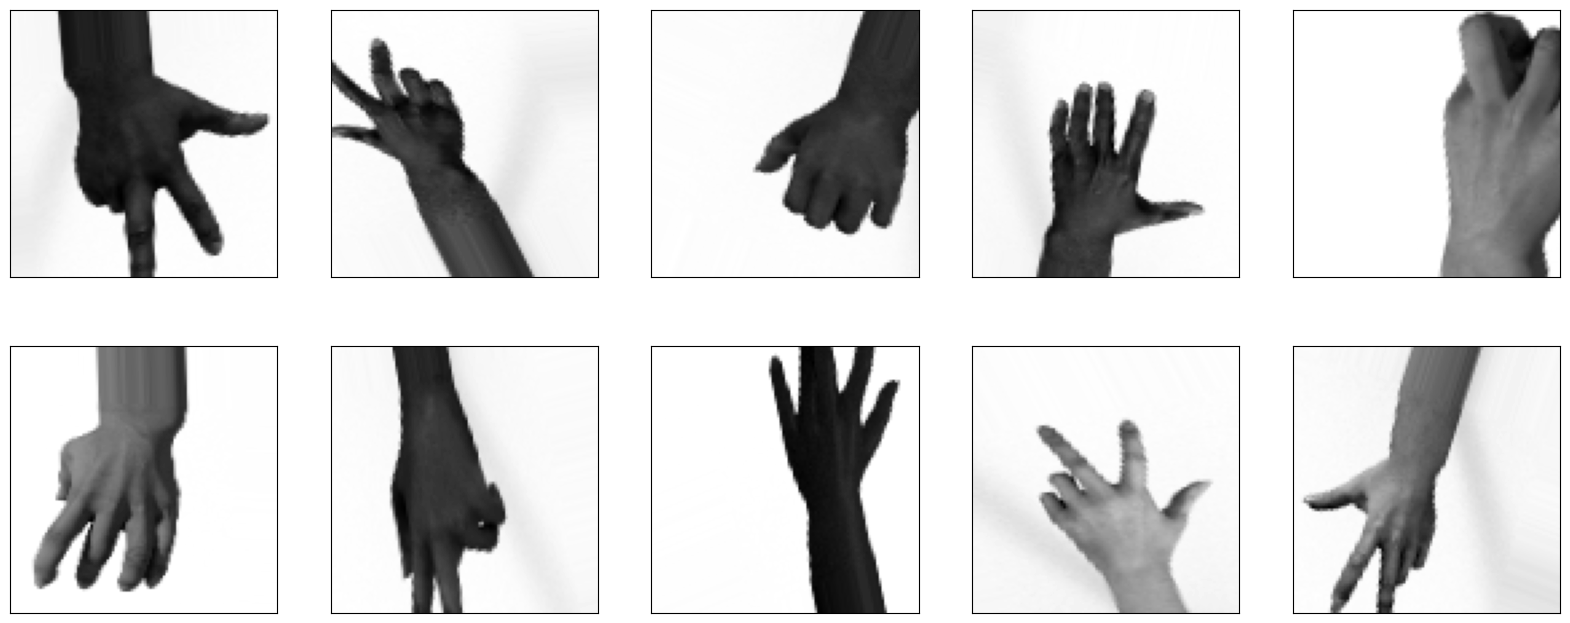

In [ ]:
#Realizar el aumento de datos con varias transformaciones. Al final, graficar 10 como ejemplo
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X)

plt.figure(figsize=(20,8))

for imagen, etiqueta in datagen.flow(X, y, batch_size=10, shuffle=False):
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i].reshape(100, 100), cmap="gray")
  break

In [ ]:

modeloCNN_AD = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 clases, usar softmax
])

In [ ]:
modeloCNN_AD.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',  # Usar sparse_categorical_crossentropy
                    metrics=['accuracy'])

In [ ]:
# Separar los datos de entrenamiento y los datos de prueba en variables diferentes

# Definir el tamaño de cada conjunto
total_imagenes = len(X)
porcentaje_entrenamiento = 0.80

# Calcular el tamaño del conjunto de entrenamiento y el conjunto de validación
tamano_entrenamiento = int(total_imagenes * porcentaje_entrenamiento)
tamano_validacion = total_imagenes - tamano_entrenamiento

# Dividir los datos en conjunto de entrenamiento y conjunto de validación
X_entrenamiento = X[:tamano_entrenamiento]
X_validacion = X[tamano_entrenamiento:]

y_entrenamiento = y[:tamano_entrenamiento]
y_validacion = y[tamano_entrenamiento:]


In [ ]:
#Usar la funcion flow del generador para crear un iterador que podamos enviar como entrenamiento a la funcion FIT del modelo
data_gen_entrenamiento = datagen.flow(X_entrenamiento, y_entrenamiento, batch_size=32)

In [ ]:
print("Longitud de X_entrenamiento:", len(X_entrenamiento))
print("Longitud de y_entrenamiento:", len(y_entrenamiento))

Longitud de X_entrenamiento: 2016
Longitud de y_entrenamiento: 2016


In [ ]:
tensorboardCNN_AD = TensorBoard(log_dir='logs/cnn_AD')

modeloCNN_AD.fit(
    data_gen_entrenamiento,
    epochs=25,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=None,  # Utilizar automáticamente el número de pasos
    validation_steps=len(X_validacion) // 32,
    callbacks=[tensorboardCNN_AD]
)


Epoch 1/25
63/63 [==============================] - 6s 61ms/step - loss: 1.0817 - accuracy: 0.3864 - val_loss: 0.9032 - val_accuracy: 0.6171
Epoch 2/25
63/63 [==============================] - 2s 37ms/step - loss: 0.9485 - accuracy: 0.5144 - val_loss: 0.6614 - val_accuracy: 0.7837
Epoch 3/25
63/63 [==============================] - 2s 39ms/step - loss: 0.7796 - accuracy: 0.6429 - val_loss: 0.4408 - val_accuracy: 0.8710
Epoch 4/25
63/63 [==============================] - 3s 40ms/step - loss: 0.5927 - accuracy: 0.7564 - val_loss: 0.2896 - val_accuracy: 0.8810
Epoch 5/25
63/63 [==============================] - 4s 56ms/step - loss: 0.4955 - accuracy: 0.7996 - val_loss: 0.5918 - val_accuracy: 0.7897
Epoch 6/25
63/63 [==============================] - 3s 41ms/step - loss: 0.4524 - accuracy: 0.8239 - val_loss: 0.2472 - val_accuracy: 0.9266
Epoch 7/25
63/63 [==============================] - 3s 39ms/step - loss: 0.4525 - accuracy: 0.8249 - val_loss: 0.1268 - val_accuracy: 0.9583
Epoch 8/25
63

In [ ]:
# 1. Cargar una imagen de prueba
image_path = '/content/s4.jpeg'
test_image = cv2.imread(image_path)

# Verificar si la imagen se ha cargado correctamente
if test_image is None:
    print("Error: No se pudo cargar la imagen de prueba.")
else:
    # Preprocesar la imagen
    test_image = cv2.resize(test_image, (TAMANO_IMG, TAMANO_IMG))
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_image_input = test_image_gray.reshape(1, TAMANO_IMG, TAMANO_IMG, 1).astype(float) / 255

    # Utilizar el modelo entrenado para predecir la clase
    predictions = modeloCNN_AD.predict(test_image_input)

    # Interpretar la salida de la predicción
    class_indices = {0: "Piedra", 1: "Papel", 2: "Tijera"}  # Mapear índices de clase a nombres de clase
    predicted_class_index = np.argmax(predictions)  # Obtener el índice de la clase con la mayor probabilidad
    predicted_class = class_indices[predicted_class_index]  # Obtener el nombre de la clase predicha

    print("La imagen es:", predicted_class)



1/1 [==============================] - 0s 19ms/step
La imagen es: Tijera


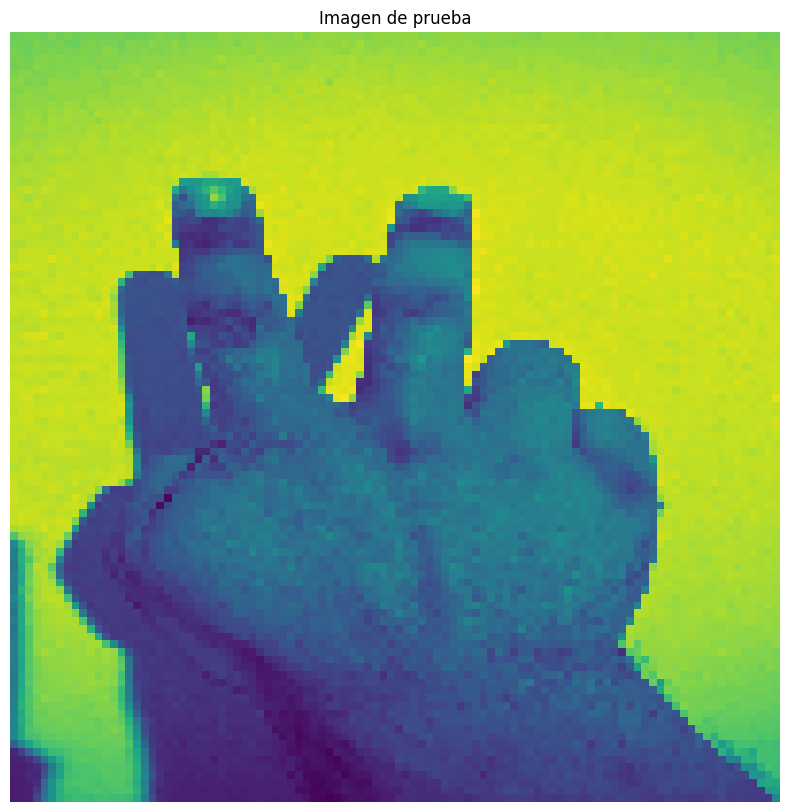

In [ ]:
# prompt: mostrar imagen generada

plt.figure(figsize=(10, 10))

plt.imshow(test_image_gray)
plt.title("Imagen de prueba")
plt.axis("off")
plt.show()
